<h2>Titter sentiment analysis</h2>

In [3]:
import os
import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime
import re
import cv2

In [211]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

In [212]:
set_up_ssl()
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dennisfenchenko/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [213]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [214]:
print("Authenticating to Twitter...")

# client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN)
client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)

Authenticating to Twitter...


In [215]:
# create Twitter API client
api = tweepy.API(auth, wait_on_rate_limit=True)

In [216]:
def get_tweets_for_user(username, names, num_tweets):

    search_query = username + " OR "

    # include all possible candidate names in a query
    for name in names:
        search_query += "entity:" + '"' + name + '"' + " OR "

    # remove the last OR statement
    search_query = search_query[:-3]

    search_query += "-is:retweet"

    print("Using the following search query to find all tweets:", search_query)

    tweets = api.search_tweets(q = search_query, count = num_tweets,
                               tweet_mode="extended",
                           lang="en", result_type="popular")
    return tweets

In [217]:
print("Fetching tweets for two candidates")

NUM_TWEETS = 100

democratic_candidate_names = ["John Fetterman", "Fetterman"]
dem_cand_username = "@JohnFetterman"

republic_candidate_names = ["Dr. Oz", "Dr Oz", "Dr. Mehmet Oz",
                           "Mehmet Oz"]
rep_cand_username = "@DrOz"

democratic_tweets = get_tweets_for_user(dem_cand_username,
                                        democratic_candidate_names, NUM_TWEETS)

republican_tweets = get_tweets_for_user(rep_cand_username,
                                        republic_candidate_names,
                                        NUM_TWEETS)

Fetching tweets for two candidates
Using the following search query to find all tweets: @JohnFetterman OR entity:"John Fetterman" OR entity:"Fetterman" -is:retweet
Using the following search query to find all tweets: @DrOz OR entity:"Dr. Oz" OR entity:"Dr Oz" OR entity:"Dr. Mehmet Oz" OR entity:"Mehmet Oz" -is:retweet


In [218]:
print("The numeber of tweets fetch for each candidate is: ")
print("Democratic candidate ", len(democratic_tweets))
print("Republican candidate ", len(republican_tweets))

The numeber of tweets fetch for each candidate is: 
Democratic candidate  15
Republican candidate  15


In [219]:
def convert_tweets_to_json(raw_tweets):
    json_tweets = []
    for tweet in raw_tweets:
        json_tweet_str = json.dumps(tweet._json)
        json_tweet = json.loads(json_tweet_str)
        json_tweets.append(json_tweet)
    return json_tweets

In [220]:
print("Converting democratic tweets to json")
democratic_json_tweets = convert_tweets_to_json(democratic_tweets)

print("Converting republican tweets to json")
republican_json_tweets = convert_tweets_to_json(republican_tweets)

Converting democratic tweets to json
Converting republican tweets to json


In [221]:
def write_json_tweets_to_file(json_tweets, TWEETS_DIR, FILE_NAME):
    tweets_file = open(TWEETS_DIR + FILE_NAME, "a")
    tweets_file_str = json.dumps(json_tweets)
    tweets_file.write(tweets_file_str)
    tweets_file.close()

In [222]:
print("Writing tweets to a file")

TWEETS_DIR = "tweets/"

DEMOCRATIC_TWEETS_FILE_NAME = "democratic_tweets.json"
REPUBLICAN_TWEETS_FILE_NAME = "republican_tweets.json"

write_json_tweets_to_file(democratic_json_tweets, TWEETS_DIR, DEMOCRATIC_TWEETS_FILE_NAME)

write_json_tweets_to_file(republican_json_tweets, TWEETS_DIR, REPUBLICAN_TWEETS_FILE_NAME)

Writing tweets to a file


In [223]:
def read_tweets_from_file(file_name):
    with open(TWEETS_DIR + file_name, "r") as tweets_file:
        tweets = json.load(tweets_file)
    return tweets

In [224]:
print("Retrieving the tweets for both candidates from file")

READ_TWEETS_FROM_FILE = False

if READ_TWEETS_FROM_FILE:
    democratic_json_tweets = read_tweets_from_file(DEMOCRATIC_TWEETS_FILE_NAME)
    republican_json_tweets = read_tweets_from_file(REPUBLICAN_TWEETS_FILE_NAME)

Retrieving the tweets for both candidates from file


In [225]:
print("Creating Vader sentiment analyzer object")

sentiment = SentimentIntensityAnalyzer()

Creating Vader sentiment analyzer object


In [227]:
#sample json file is

democratic_json_tweets[0]

{'created_at': 'Thu Oct 13 14:41:39 +0000 2022',
 'id': 1580569460226011137,
 'id_str': '1580569460226011137',
 'full_text': 'Dr. Oz kills puppies, wants to ban abortion, and can’t remember how many homes he has. \n\nI’m voting for @JohnFetterman, a man who will give a damn about families like mine.',
 'truncated': False,
 'display_text_range': [0, 172],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'JohnFetterman',
    'name': 'John Fetterman',
    'id': 3622368202,
    'id_str': '3622368202',
    'indices': [104, 118]}],
  'urls': []},
 'metadata': {'result_type': 'popular', 'iso_language_code': 'en'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 2729615444,
  'id_str': '2729615444',
  'name': 'Rep. Malcolm Kenyatta',

In [228]:
print("Use this function to clean the tweet's body")

def clean_tweet(tweet_body):
    # remove @ mentions from the tweet
    text = re.sub(r'@[A-Za-z0-9]+', '', tweet_body)
    # remove the hashtags from tweets
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

Use this function to clean the tweet's body


In [229]:
# this function return a list containing the following triplets: [(date,
# tweet_neutral_score, tweet_negative_score)]
print("The tweet's neutrality and negativity scores are scaled by the number "
      "of retweets the tweet has received.")

def get_tweet_sentiment_score(tweets):
    sentiments = []
    for tweet in tweets:
        timestamp = tweet["created_at"]
        datetime_timestamp = datetime.strftime(datetime.strptime(timestamp,'%a %b %d '
                                                                   '%H:%M:%S +0000 %Y'), '%Y-%m-%d')
        tweet_body = clean_tweet(tweet["full_text"])
        retweet_count = tweet["retweet_count"]
        tweet_sentiment = sentiment.polarity_scores(tweet_body)
        tweet_neg_score = tweet_sentiment['neg'] * retweet_count
        tweet_neu_score = tweet_sentiment['neu'] * retweet_count
        sentiments.append((datetime_timestamp, tweet_neu_score,
                           tweet_neg_score))
    return sentiments

The tweet's neutrality and negativity scores are scaled by the number of retweets the tweet has received.


In [230]:
print("Getting sentiment scores for each candidate")

democratic_sentiments = get_tweet_sentiment_score(democratic_json_tweets)

republican_sentiments = get_tweet_sentiment_score(republican_json_tweets)

Getting sentiment scores for each candidate


In [231]:
print("Analysis for democratic candidate yields:")
print(democratic_sentiments)

Analysis for democratic candidate yields:
[('2022-10-13', 712.4190000000001, 258.213), ('2022-10-13', 2790.7200000000003, 269.28), ('2022-10-13', 565.056, 0.0), ('2022-10-13', 594.562, 0.0), ('2022-10-13', 481.194, 86.229), ('2022-10-13', 363.09000000000003, 0.0), ('2022-10-13', 230.65200000000002, 27.348), ('2022-10-13', 404.225, 32.775), ('2022-10-13', 147.312, 28.709999999999997), ('2022-10-13', 181.5, 44.25), ('2022-10-13', 242.0, 0.0), ('2022-10-14', 60.753, 0.0), ('2022-10-14', 87.0, 0.0), ('2022-10-13', 143.756, 22.244), ('2022-10-13', 457.056, 0.0)]


In [232]:
print("Analysis for republican candidate yields:")
print(republican_sentiments)

Analysis for republican candidate yields:
[('2022-10-14', 676.8199999999999, 0.0), ('2022-10-14', 458.48, 390.72), ('2022-10-13', 326.696, 94.304), ('2022-10-14', 474.56399999999996, 82.43599999999999), ('2022-10-13', 197.0, 0.0), ('2022-10-13', 51.70400000000001, 23.092), ('2022-10-13', 60.64, 6.640000000000001), ('2022-10-14', 73.08, 10.92), ('2022-10-14', 48.0, 0.0), ('2022-10-13', 40.849999999999994, 4.65), ('2022-10-13', 45.45, 0.0), ('2022-10-13', 48.95, 0.0), ('2022-10-13', 52.983999999999995, 15.392), ('2022-10-14', 46.872, 16.128), ('2022-10-13', 13.86, 3.7199999999999998)]


In [255]:
def get_date_score_mapping(candidate_sentiments):
    candidate_total_sentiment = {}
    DATE_IDX = 0
    NEUTRAL_SCORE_IDX = 1
    NEGATIVE_SCORE_IDX = 2

    for sent in candidate_sentiments:
        date = sent[DATE_IDX]
        if date in candidate_total_sentiment.keys():
            curr_neutral_score = \
                candidate_total_sentiment[date][0]
            curr_negative_score = candidate_total_sentiment[date][1]
            curr_neutral_score += sent[NEUTRAL_SCORE_IDX]
            curr_negative_score += sent[NEGATIVE_SCORE_IDX]
            candidate_total_sentiment[date] = (curr_neutral_score, curr_negative_score)
        else:
            candidate_total_sentiment[date] = (sent[NEUTRAL_SCORE_IDX], sent[NEGATIVE_SCORE_IDX])

    return candidate_total_sentiment

In [256]:
print("Creating date-sentiment map for each candidate: ")

democratic_total_sentiment = get_date_score_mapping(democratic_sentiments)

republican_total_sentiment = get_date_score_mapping(republican_sentiments)

Creating date-sentiment map for each candidate: 


In [257]:
print("The sentiment map for democratic candidate is: ")

print(democratic_total_sentiment)

The sentiment map for democratic candidate is: 
{'2022-10-13': (7313.542000000001, 769.049), '2022-10-14': (147.753, 0.0)}


In [258]:
print("The sentiment map for republican candidate is: ")

print(republican_total_sentiment)

The sentiment map for republican candidate is: 
{'2022-10-14': (1777.816, 500.204), '2022-10-13': (838.1340000000002, 147.798)}


In [259]:
democratic_dates = list(democratic_total_sentiment.keys())
democratic_sent = list(democratic_total_sentiment.values())

democratic_neu_sent = [x[0] for x in democratic_sent]
democratic_neg_sent = [x[1] for x in democratic_sent]


republican_dates = list(republican_total_sentiment.keys())
republican_sent = list(republican_total_sentiment.values())

republican_neu_sent = [x[0] for x in republican_sent]
republican_neg_sent = [x[1] for x in republican_sent]

Plotting the data for the democratic candidate: 


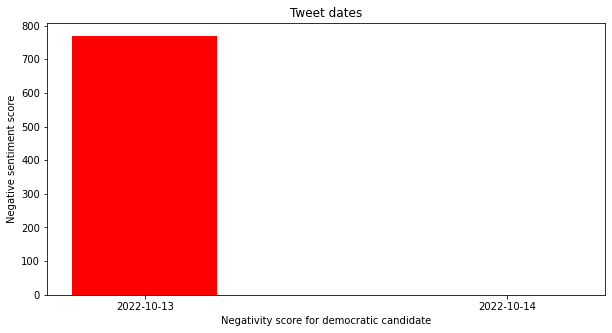

In [260]:
print("Plotting the data for the democratic candidate: ")

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(democratic_dates, democratic_neg_sent, color ='red',
        width = 0.4)

plt.xlabel("Negativity score for democratic candidate")
plt.ylabel("Negative sentiment score")
plt.title("Tweet dates")
plt.show()

Plotting the data for the republican candidate: 


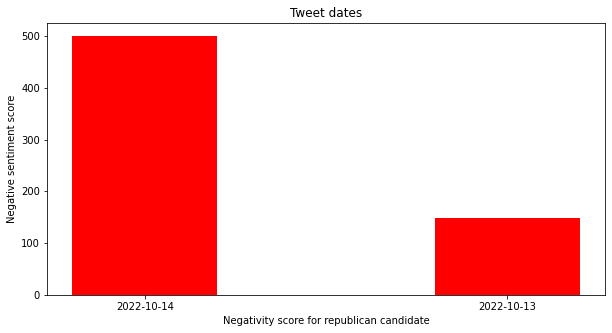

In [261]:
print("Plotting the data for the republican candidate: ")

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(republican_dates, republican_neg_sent, color ='red',
        width = 0.4)

plt.xlabel("Negativity score for republican candidate")
plt.ylabel("Negative sentiment score")
plt.title("Tweet dates")
plt.show()

In [265]:
print("Plotting Word Clouds for each candidate:")

print("Generating a word cloud for the democratic candidate:")

all_democrat_candidates_tokens = ' '.join(token["full_text"] for token in
                                          democratic_json_tweets)

all_republican_candidates_tokens = ' '.join(token["full_text"] for token in
                                          republican_json_tweets)

# clean the tweets

all_democrat_candidates_tokens = clean_tweet(all_democrat_candidates_tokens)
all_republican_candidates_tokens = clean_tweet(all_republican_candidates_tokens)

dem_word_cloud = WordCloud(random_state=21,
                           max_font_size=119).generate(all_democrat_candidates_tokens)

rep_word_cloud = WordCloud(width = 500, height = 300, random_state=21,
                           max_font_size=119).generate(all_republican_candidates_tokens)

Plotting Word Clouds for each candidate:
Generating a word cloud for the democratic candidate:


Visualizing word cloud for the democrat


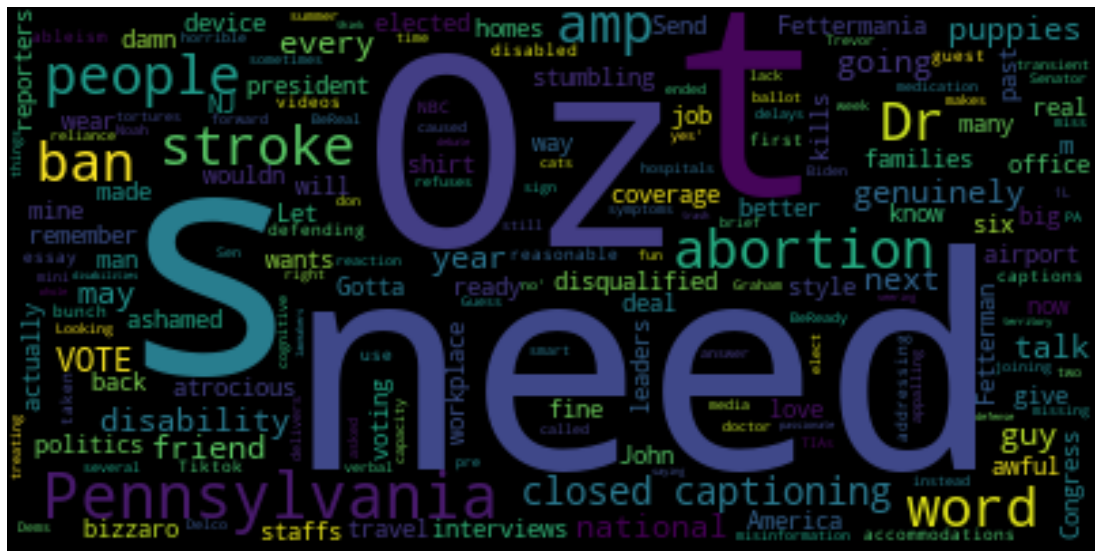

In [266]:
print("Visualizing word cloud for the democrat")

plt.figure(figsize=(20,10))
plt.imshow(dem_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Visualizing word cloud for the republican candidate


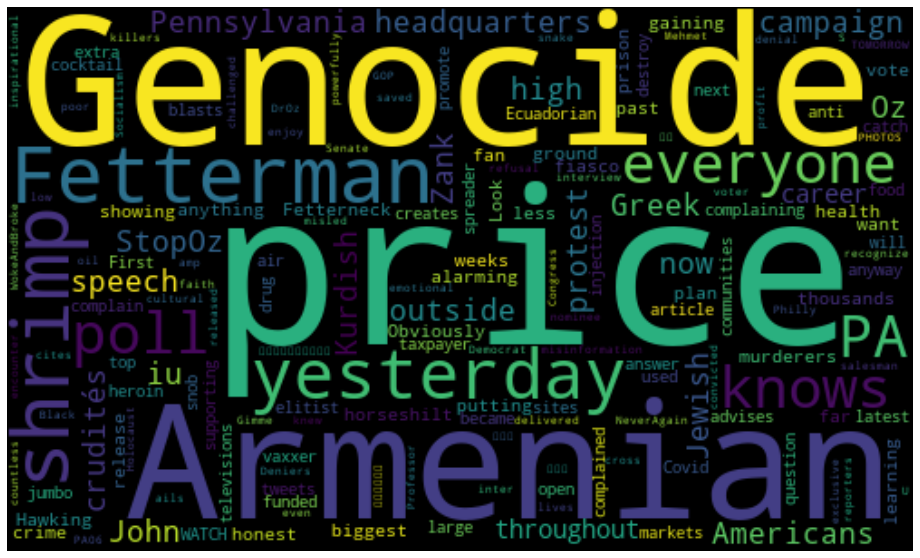

In [267]:
print("Visualizing word cloud for the republican candidate")

plt.figure(figsize=(20,10))
plt.imshow(rep_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The current polls show the following:


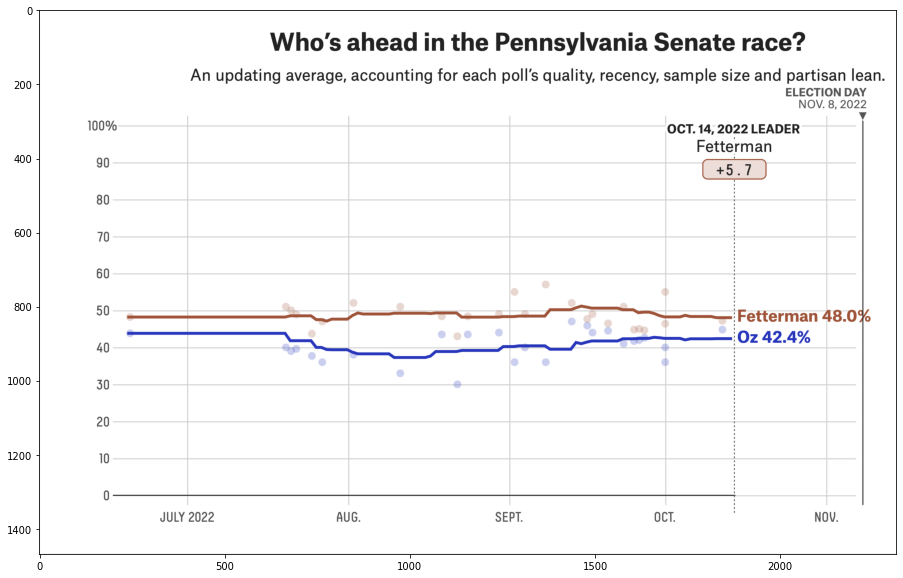

In [5]:
print("The current polls show the following:")

polls_latest = cv2.imread("polls_latest.png", cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(20,10))
plt.imshow(polls_latest)
plt.show()

<h2>Analysis of the results above<h2>

From sentiment analysis we can observe that tweets about the Republican
candidate Dr. Oz are more negative than those that are about the Democratic
candidate.

Another interesting conclusion can be derived from the Word Clouds above.

For John Fetterman the word cloud shows words such as "Stroke" and "Health"
being some of the most frequently used. This refers to Fetterman having had a
 stroke back in May, which is frequently used against him.

For Mehmet Oz, we can see interesting words such as "puppies", "killed", and
"fraud". The first words refer to the research he's done in the past which
allegedly led to the killing of 300 puppies. And the thord one refers to him
advertising dubious treatments on a TV commercial. Both stories are used
against him by the opponents.